In [1]:
import copy
import gc
import glob
import os
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import signal
from scipy.fft import fft, fftfreq
import scipy.io as sio

In [2]:


def get_date(file_path):
    #取session name
    file_name_splited = file_path.split('\\')
    session_all_name = file_name_splited [-1]
    date_name = session_all_name.split('_')[0][:8]
    
    return date_name

def days_between_dates(date1, date2):
    # 将日期字符串转换为datetime对象
    date_format = "%Y%m%d"
    d1 = datetime.strptime(date1, date_format)
    d2 = datetime.strptime(date2, date_format)
    
    # 计算两个日期之间的差值，并返回天数
    delta = d2 - d1
    return abs(delta.days)  # 使用abs确保返回非负数


def sort_ECoG_filename(filename):
    # 提取文件名中的数字并转换为整数
    indices = [int(f.split('ch')[-1].split('.mat')[0]) for f in filename]

    # 使用NumPy的argsort进行索引排序
    sorted_indices = np.argsort(indices)

    # 根据排序后的索引重排文件列表
    sorted_files = np.array(filename)[sorted_indices]

    #重新变回列表
    return sorted_files.tolist()

In [3]:
def get_one_session_ECoG_data(file_pooling):
    ECoG_pooling=[]
    
    #把所有ECoG文件名字按照channel numb sorted
    file_pooling =sort_ECoG_filename(filename=file_pooling)
    
    for ch_index, full_file_name in enumerate(file_pooling):
        #print(full_file_name)
        #得到全部的数据
        data = sio.loadmat(full_file_name)
        
        #只提取ECoG数据
        ECoG_data = data[''.join(['ECoGData_ch',str(ch_index+1)])]
        #print(ECoG_data.shape)
        
        # 1 x time -> time
        ECoG_pooling.append(ECoG_data.reshape(-1))
    
    return np.array(ECoG_pooling)

In [4]:

# 指定要遍历的文件夹路径
folder_path = r"D:\code\YMa_datasets\food_tracking_data\Epidural"

all_std = []
diff_days_pooling = []
session_dates=[]
# 使用os.walk()函数遍历文件夹及其子文件夹
for root, dirs, files in os.walk(folder_path):

    # 打印当前文件夹下的所有文件
    for dir_ in dirs:
        
        file_path = os.path.join(root, dir_)
        print(f"  abs file name: {dir_}")
        
        # 搜索所有匹配的文件
        file_pooling = glob.glob(f"{file_path}/ECoG_ch*.mat")
        
        #读取原始ECoG文件
        one_session_data =get_one_session_ECoG_data(file_pooling)
        print(one_session_data.shape)
        
        #一个session的std
        one_session_std = np.std(one_session_data,axis=-1)
        all_std.append(one_session_std)
        
        #日期
        session_date = get_date(file_path)
        session_dates.append(session_date)
        
        #相差几天
        diff_days = days_between_dates(date1='20100623', 
                           date2=session_date)
        
        diff_days_pooling.append(diff_days)
        print(session_date,diff_days)
        #break

  abs file name: 20100623S1_Epidural-ECoG+Food-Tracking_B_Kentaro+Shimoda_mat_ECoG64-Motion6
(64, 1026829)
20100623 0
  abs file name: 20100624S1_Epidural-ECoG+Food-Tracking_B_Kentaro+Shimoda_mat_ECoG64-Motion6
(64, 1031045)
20100624 1
  abs file name: 20100628S1_Epidural-ECoG+Food-Tracking_B_Kentaro+Shimoda_mat_ECoG64-Motion6
(64, 1046823)
20100628 5
  abs file name: 20100701S1_Epidural-ECoG+Food-Tracking_B_Kentaro+Shimoda_mat_ECoG64-Motion6
(64, 1032868)
20100701 8
  abs file name: 20100705S1_Epidural-ECoG+Food-Tracking_B_Kentaro+Shimoda_mat_ECoG64-Motion6
(64, 1036235)
20100705 12
  abs file name: 20100708S1_Epidural-ECoG+Food-Tracking_B_Kentaro+Shimoda_mat_ECoG64-Motion6
(64, 1040815)
20100708 15
  abs file name: 20100712S1_Epidural-ECoG+Food-Tracking_B_Kentaro+Shimoda_mat_ECoG64-Motion6
(64, 1035036)
20100712 19
  abs file name: 20100726S1_Epidural-ECoG+Food-Tracking_B_Kentaro+Shimoda_mat_ECoG64-Motion6
(64, 1030675)
20100726 33
  abs file name: 20100802S1_Epidural-ECoG+Food-Track

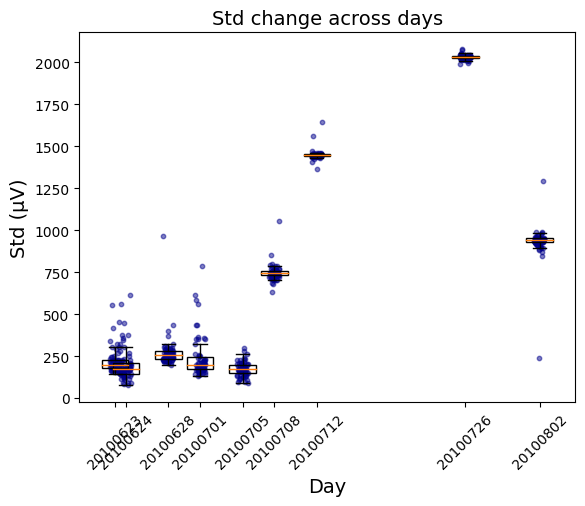

In [5]:


diff_days_pooling = np.array(diff_days_pooling)


# 绘制箱线图
fig, ax = plt.subplots()#figsize=(12, 6
boxplot_elements = ax.boxplot(all_std,
                              positions=diff_days_pooling*2,
                              widths=5, 
                              patch_artist=True, 
                              showfliers=False,
                             boxprops=dict(facecolor='None')
                              )#positions=[1, 2],boxprops=dict(facecolor='lightblue')

# 添加散点图#widths=np.repeat(10,len(diff_days_pooling))
# 散点图中每个点的位置
for i, (d,st) in enumerate(zip(diff_days_pooling,all_std)):
    # 'jitter' 小的随机噪声，使点不会完全重叠
    jitter = 2 * np.random.rand(len(st)) -1
    ax.scatter(d*2 + jitter, st, color='darkblue', alpha=0.5, s=10)

ax.set_xticklabels(session_dates,rotation=45, fontsize=10)
ax.set_title('Std change across days', fontsize=14)
ax.set_ylabel('Std (μV)', fontsize=14)
ax.set_xlabel('Day', fontsize=14)
plt.show()